# Libraries

In [58]:
import os
import cv2
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
plt.style.use("ggplot")
import time

# Data Preparation

In [ ]:
!7z x /kaggle/input/cifar-10/train.7z

In [3]:
train_folder = "/kaggle/working/train"
print("Number of training images are ", len(os.listdir(train_folder)))

Number of training images are  50000


In [4]:
df = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")
df.iloc[1]["label"]
df.head(9)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship


In [5]:
label_list = df["label"].unique()
count = 0 
dic = {}
for i in label_list:
    dic[i] = count
    count = count+1

dic

{'frog': 0,
 'truck': 1,
 'deer': 2,
 'automobile': 3,
 'bird': 4,
 'horse': 5,
 'ship': 6,
 'cat': 7,
 'dog': 8,
 'airplane': 9}

In [6]:
x_train = []
y_train = []
for i in tqdm(os.listdir(train_folder)):
    img_path = os.path.join(train_folder, i)
    img = cv2.imread(img_path)
    id_number = i.split(".")[0]
    index = df.index[(df["id"]==int(id_number))==True].values[0]
    cls_id = df.iloc[index]["label"]
    x_train.append(img)
    y_train.append(int(dic[cls_id]))

100%|██████████| 50000/50000 [00:35<00:00, 1413.71it/s]


In [7]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
class Data(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.images = x
        self.labels = y
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = self.images[index]
        target = self.labels[index]
        if(self.transform is not None):
            image = self.transform(image)
        return image, target
    

In [9]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225])
])

In [10]:
train_data = Data(x_train, y_train, train_transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                                 batch_size=32)

# Mobile_Net_V3_Small

In [11]:
mobile_net = torchvision.models.mobilenet_v3_small(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [13]:
for i in mobile_net.features.parameters():
    i.requires_grade = False

In [14]:
mobile_net.classifier[-1] = torch.nn.Linear(1024,10)
for i in mobile_net.classifier.parameters():
    i.requires_grad = True

In [19]:
if(torch.cuda.is_available()):
    print("Device is GPU")
    device = torch.device("cuda")
else:
    print("Device is CPU")
    device = torch.device("cpu")

model = mobile_net
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

Device is GPU


In [20]:
lrs = []
train_acc = []
ep_loss = []
for epoch in range(0,10):
    print("Epoch : ",epoch)
    epoch_loss = 0
    batches = 0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        batches+=1
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs=model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    train_accuracy = 0
    for inputs,targets in tqdm(train_loader):
        inputs = inputs.to(device)
        outputs = model(inputs).detach().cpu().numpy().argmax(axis=-1)
        train_accuracy += (outputs == targets.numpy()).mean()
    train_accuracy = train_accuracy/batches
    train_acc.append(train_accuracy)
    ep_loss.append(epoch_loss)
    print("Train accuracy on Batch of {} images is {} ".format(batches, train_accuracy))
    print("Loss is ", epoch_loss)

Epoch :  0


100%|██████████| 1563/1563 [01:49<00:00, 14.27it/s]


Train accuracy on Batch of 1563 images is 0.9500959692898272 
Loss is  353.0218863543123
Epoch :  1


100%|██████████| 1563/1563 [01:50<00:00, 14.18it/s]


Train accuracy on Batch of 1563 images is 0.9561540307101728 
Loss is  288.4197753749322
Epoch :  2


100%|██████████| 1563/1563 [01:49<00:00, 14.27it/s]


Train accuracy on Batch of 1563 images is 0.9713491682661548 
Loss is  165.4049703370547
Epoch :  3


100%|██████████| 1563/1563 [01:49<00:00, 14.30it/s]


Train accuracy on Batch of 1563 images is 0.9790267114523352 
Loss is  132.50482798201847
Epoch :  4


100%|██████████| 1563/1563 [01:49<00:00, 14.27it/s]


Train accuracy on Batch of 1563 images is 0.9863243761996161 
Loss is  78.6158127936942
Epoch :  5


100%|██████████| 1563/1563 [01:49<00:00, 14.33it/s]


Train accuracy on Batch of 1563 images is 0.9877639155470249 
Loss is  64.29817695113161
Epoch :  6


100%|██████████| 1563/1563 [01:48<00:00, 14.45it/s]


Train accuracy on Batch of 1563 images is 0.9925623800383877 
Loss is  35.60942591874118
Epoch :  7


100%|██████████| 1563/1563 [01:48<00:00, 14.41it/s]


Train accuracy on Batch of 1563 images is 0.994841650671785 
Loss is  32.91613756067545
Epoch :  8


100%|██████████| 1563/1563 [01:51<00:00, 14.05it/s]


Train accuracy on Batch of 1563 images is 0.9974608125399872 
Loss is  17.61472761500886
Epoch :  9


100%|██████████| 1563/1563 [01:52<00:00, 13.92it/s]

Train accuracy on Batch of 1563 images is 0.9960812539987204 
Loss is  15.984057081031551


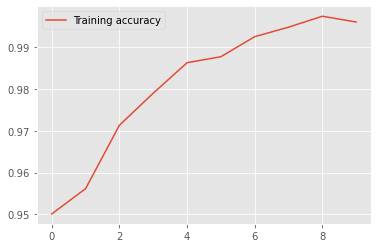

In [21]:
plt.plot(train_acc, label="Training accuracy")
plt.legend()
plt.show()

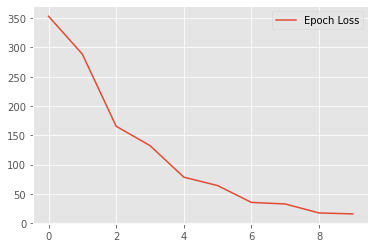

In [23]:
plt.plot(ep_loss, label="Epoch Loss")
plt.legend()
plt.show()

# Kaggle Submission

In [ ]:
!7z x /kaggle/input/cifar-10/test.7z

In [35]:
test_folder = "/kaggle/working/test"
print(len(os.listdir(test_folder)))
os.listdir(test_folder)[2]

300000


'202798.png'

In [49]:
count = 0
reverse_labels = {}
for i in dic.keys():
    reverse_labels[count] = i
    count = count + 1

In [52]:
dic

{'frog': 0,
 'truck': 1,
 'deer': 2,
 'automobile': 3,
 'bird': 4,
 'horse': 5,
 'ship': 6,
 'cat': 7,
 'dog': 8,
 'airplane': 9}

In [53]:
reverse_labels

{0: 'frog',
 1: 'truck',
 2: 'deer',
 3: 'automobile',
 4: 'bird',
 5: 'horse',
 6: 'ship',
 7: 'cat',
 8: 'dog',
 9: 'airplane'}

Prediction is  cat


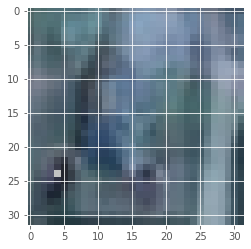

In [56]:
img = cv2.imread("/kaggle/working/test/202.png")
infer_model = model.eval()
img = train_transform(img).to(device)
img = img.unsqueeze(0)
predicted_cls = infer_model(img).argmax(axis=-1).item()
plt.imshow(cv2.imread("/kaggle/working/test/202.png"))
print("Prediction is ", reverse_labels[predicted_cls])

In [59]:
col1, col2 = [], []
with torch.no_grad():
    a = time.time()
    for i in tqdm(os.listdir(test_folder)):
        id = i.split(".")[0]
        col1.append(id)
        img = cv2.imread(os.path.join(test_folder, i))
        img = train_transform(img).to(device)
        img = img.unsqueeze(0)
        predicted_cls = infer_model(img).argmax(axis=-1).item()
        label = reverse_labels[predicted_cls]
        col2.append(label)
    print("Time taken is ", time.time()-a)

100%|██████████| 300000/300000 [37:59<00:00, 131.61it/s]

Time taken is  2279.5696120262146


In [65]:
sub = pd.DataFrame(list(zip(col1,col2)),
             columns = ["id", "label"])

sub.to_csv("submission.csv", index=False)

**93.87 Accuracy on Submission**

# Conversion to Torchscript

In [68]:
traced_script_model = torch.jit.trace(model, img)
traced_script_model.save("model_torchscript.pt")

In [71]:
col1, col2 = [], []
with torch.no_grad():
    a = time.time()
    for i in tqdm(os.listdir(test_folder)):
        id = i.split(".")[0]
        col1.append(id)
        img = cv2.imread(os.path.join(test_folder, i))
        img = train_transform(img).to(device)
        img = img.unsqueeze(0)
        predicted_cls = traced_script_model(img).argmax(axis=-1).item()
        label = reverse_labels[predicted_cls]
        col2.append(label)
    print("Time taken is ", time.time()-a)

100%|██████████| 300000/300000 [25:45<00:00, 194.05it/s]

Time taken is  1546.138691663742


In [72]:
sub = pd.DataFrame(list(zip(col1,col2)),
             columns = ["id", "label"])

sub.to_csv("submission2.csv", index=False)

**93.87 Accuracy**